In [1]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

from utils import (
    logging,
    TRAINING_DATA_FILE,
    TRAINING_LOSSES_PLOT,
    MUTATION_SCORES_FILE,
)
from utils.modelling import Fixynergy, MutationDataset

use_cuda = torch.cuda.is_available()
# use_cuda = False
device = torch.device("cuda:0" if use_cuda else "cpu")
logging.info(f"Using device {device}")

n_factors = 10

batch_size = 128
shuffle = True
learning_rate = 1e-4
weight_decay = 1e-5
n_epochs = 100


In [2]:
logging.info("Load data...")
seq_mut: pd.DataFrame = pd.read_feather(TRAINING_DATA_FILE)

training_data = MutationDataset(seq_mut)

model = Fixynergy(
    n_seq=training_data.n_seq,
    n_pos=training_data.n_pos,
    n_factors=n_factors,
    n_states=training_data.n_states
)
model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay
)


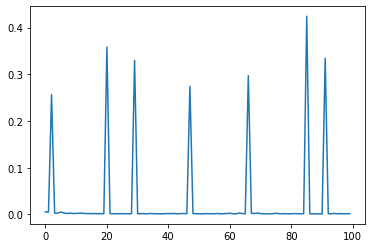

In [3]:
logging.info("Start training")

model.train()

losses = []
seq_ids: torch.Tensor
pos_ids: torch.Tensor
targets: torch.Tensor
pred: torch.Tensor
loss: torch.Tensor
for epoch in range(n_epochs):
    # training_data.balance_values()
    for (seq_ids, pos_ids), targets in DataLoader(
        training_data,
        batch_size=batch_size,
        shuffle=shuffle
    ):
        seq_ids = seq_ids.to(device)
        pos_ids = pos_ids.to(device)

        pred = model(seq_ids, pos_ids)
        targets = targets.to(device)
        # targets = targets.float().view(pred.size())
        loss: torch.Tensor = loss_fn(pred, targets.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    logging.info(f"{epoch + 1}/{n_epochs}, loss: {loss.item()}")
    losses.append({
        "epoch": epoch,
        "loss": loss.item()
    })

losses = pd.DataFrame.from_records(losses, index="epoch")

# plt.plot(losses[losses.index > n_epochs * 0.2]["loss"])
plt.plot(losses["loss"])
plt.savefig(TRAINING_LOSSES_PLOT)
logging.info(f"{TRAINING_LOSSES_PLOT} saved!")

In [58]:
logging.info("AA score matrix")

model.eval()

aa_mapping = dict(seq_mut[["AA_idx", "AA"]].drop_duplicates().values)
n_pos = len(training_data.pos_id2name)
aa_scores = []
with torch.no_grad():
    for seq_id, seq_name in training_data.seq_id2name.items():
        seq_ids = torch.Tensor(torch.Tensor([seq_id] * n_pos)).int().to(device)
        pos_ids = torch.Tensor(training_data.pos_id2name.index).int().to(device)
        pred: torch.Tensor = model(seq_ids, pos_ids)
        scores = pd.DataFrame(pred.data.cpu().numpy())
        scores = scores.rename(columns=aa_mapping)
        scores["Pos"] = training_data.pos_id2name.values
        scores["Accession"] = seq_name
        aa_scores.append(scores)

aa_scores: pd.DataFrame = pd.concat(aa_scores).reset_index(drop=True)
aa_scores.to_feather(MUTATION_SCORES_FILE)
logging.info(f"{MUTATION_SCORES_FILE} saved!")
